In [1]:
from typing import List
import numpy as np
from shapely.geometry import MultiPolygon
import matplotlib.pyplot as plt
from geospatial_optimization import optimize_sensor_placement, calculate_coverage_info, plot_sensor_map, export_to_geojson
# This area is defined by a set of polygons representing the operational boundaries.
operational_area = MultiPolygon(
    [
        [[
            (-15.63607,63.44591),
            (-14.87971,64.01143),
            (-13.44727,64.15853),
            (-9.47021,63.56812),
            (-7.85655,62.73101),
            (-8.02002,61.89758),
            (-9.42634,61.81594),
            (-13.02268,62.61201),
        ],[]],
        [[
            (-5.9332,61.79661),
            (-5.34871,62.16978),
            (-3.5376,61.98027),
            (-1.604,61.27023),
            (-1.4502,60.91975),
            (-2.41515,60.37148),
            (-3.83423,60.58531),
            (-5.625,61.12202),
            (-6.1084,61.53317),
        ],[]],
        [[
            (-26.06663,68.64959),
            (-24.60937,68.08971),
            (-22.58789,66.65298),
            (-24.52148,66.00015),
            (-26.5078,66.31433),
            (-28.82553,67.85732),
        ],[]],
    ]
)

In [2]:
configurations=[]

# Define azimuths in degrees
# These azimuths represent the directions in which the sensors will be oriented
azimuths = [0.0, 22.5, 45.0, 67.5, 90.0, 112.5, 135.0, 157.5, 180.0, 202.5, 225.0, 247.5, 270.0, 292.5, 315.0, 337.5]

# Generate configurations for each azimuth with different fan degrees and ranges
for a in azimuths:
    configurations.append(    
        {
            'azimuth_degree': a,
            'fan_degree': 50,
            'range_km': 130,
        } 
    )
    configurations.append(    
        {
            'azimuth_degree': a,
            'fan_degree': 90,
            'range_km': 100,
        } 
    )
    configurations.append(    
        {
            'azimuth_degree': a,
            'fan_degree': 130,
            'range_km': 70,
        } 
    )

\begin{aligned}
  & \text{Let} & 
      I         & = \text{No. of target locations} \\
  & & L         & = \text{No. of source locations} \\
  & & J         & = \text{No. of configurations} \\
  & & S         & = \text{No. of sensors} \\
  & & C_{i,l,j} & = \text{Coverage matrix} \\
  & & x_{l,j}   & = \text{Allocation matrix} \\ % IF location l with config j is allocated THEN 1 ELSE 0 END
  & & y_i       & = \text{Is convered vector} \\
  & & y_i^{'}   & = \text{Coverage count vector} \\
  & & P         & = \text{Percentage of coverage requirement} \\


  % Minimize number of sensors allocated.
  & \text{Minimize} & z & = \sum_{l=0}^{L}\sum_{j=0}^{J}x_{l,j} - \sum_{i=0}^{I}(y_i^{'}-1) \\


  & \text{Subject to} &&&&&   &\\

  % The allocation matrix x is binary
  & (1)         & x_{l,j}     & \in \{0,1\}       & \forall   & l   & = 1,2,3...,L & \\
  &             &             &                   & \forall   & j   & = 1,2,3...,J & \\

  % The cover matrix is binary
  & (2)         & y_{i}       & \in \{0,1\}       & \forall   & i   & = 1,2,3...,I & \\

  % The covered count variable is zero or a positive integer
  & (3)         & y_{i}^{'}   & \in \mathbb{Z}^{0+}   & \forall   & i   & = 1,2,3...,I & \\
 
  % Don't exceed the maximum number of available sensors
  & (4)         & x_{l,j}     & \leq S            & \forall   & l   & = 1,2,3...,L & \\
  &             &             &                   & \forall   & j   & = 1,2,3...,J & \\

  % Achieve the required percentage of grid point coverage
  & (5)         & \sum_{i=0}^{I} y_{i}
                              & \geq PI           &           &                    & \\
                              
  % The covered count variable (y_prime) should  be greater than or equal to the is_covered variable
  & (6)         & \sum_{i=0}^{I} y_{i}^{'}
                              & \geq \sum_{i=0}^{I} y_{i}
                                                  &           &                    & \\

  % Avoid excessively overlapping the sensors, currently limit at 2
  & (7)         & y_{i}       & \leq 2            & \forall   & i   & = 1,2,3...,I & \\

  % Link the is_covered variable to the placement variables
  & (8)         & \sum_{l=0}^{L}\sum_{j=0}^{J} C_{i,l,j} x_{l,j} 
                              & \geq y_i          & \forall   & i   & = 1,2,3...,I & \\
  
  % Link the covered_count variable to the placement variables
  & (9)         & \sum_{l=0}^{L}\sum_{j=0}^{J} C_{i,l,j} x_{l,j} 
                              & \geq y_i^{'}      & \forall   & i   & = 1,2,3...,I & \\

  % Ensure at most one sensor is placed at any given location
  & (10)         & \sum_{j=0}^{J}x_{l,j} 
                              & \leq 1            & \forall   & l   & = 1,2,3...,L & \\

  
\end{aligned}

In [3]:

status, placed_sensors_info = optimize_sensor_placement(
    operational_area=operational_area,
    configurations=configurations,
    resolution_km=30,
    max_sensors=99,
    coverage_requirement=0.8,
    encourage_overlapping=0.0,
)
print(f"Status: {status}")
info = calculate_coverage_info(operational_area, placed_sensors_info)
print(f"Number of sensors placed: {info['num_sensors']}")
print(f"Estimated coverage percentage: {info['estimated_coverage_percent']*100:.2f}%")
print(f"Actual Area Coverage: {info['actual_coverage_percent']*100:.2f}%")


Status: Optimal
Number of sensors placed: 12
Estimated coverage percentage: 80.14%
Actual Area Coverage: 63.30%


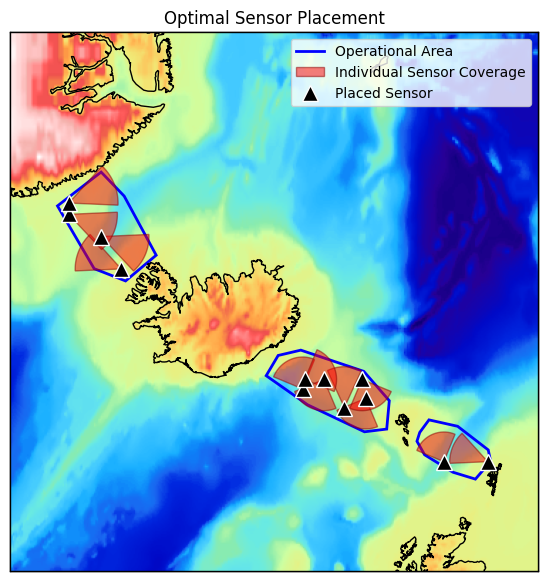

In [ ]:
ax = plot_sensor_map(operational_area, placed_sensors_info)
plt.show()

In [5]:
output_filename = "sensor_placement.geojson"


# 2. Call the export function
export_to_geojson(
    filename=output_filename,
    op_area=operational_area,
    placed_sensors=placed_sensors_info,
)